<!-- Copyright (c) 2021-2022, InterDigital Communications, Inc
All rights reserved.

Redistribution and use in source and binary forms, with or without 
modification, are permitted (subject to the limitations in the disclaimer 
below) provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, 
this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice, 
this list of conditions and the following disclaimer in the documentation 
and/or other materials provided with the distribution.
* Neither the name of InterDigital Communications, Inc nor the names of its 
contributors may be used to endorse or promote products derived from this 
software without specific prior written permission.

NO EXPRESS OR IMPLIED LICENSES TO ANY PARTY'S PATENT RIGHTS ARE GRANTED BY 
THIS LICENSE. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND 
CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT 
NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A 
PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER 
OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, 
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, 
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; 
OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, 
WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR 
OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF 
ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. -->

# Compressai Models Comparison Demo

In [2]:
import math
import torch
from torchvision import transforms
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

In [3]:
from pytorch_msssim import ms_ssim

In [4]:
from compressai.zoo import (mbt2018_mean, mbt2018, cheng2020_anchor, cheng2020_attn)

In [35]:
from ipywidgets import interact, widgets

## Global settings

In [1]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
metric = 'mse'  # only pre-trained model for mse are available for now
quality = 1     # lower quality -> lower bit-rate (use lower quality to clearly see visual differences in the notebook)

NameError: name 'torch' is not defined

## Load some pretrained models

In [ ]:
networks = {
    'mbt2018_mean_1' : mbt2018_mean(quality=1, pretrained=True).eval().to(device),
    'mbt2018_mean_2' : mbt2018_mean(quality=2, pretrained=True).eval().to(device),
    'mbt2018_mean_3' : mbt2018_mean(quality=4, pretrained=True).eval().to(device),
    'mbt2018_mean_4' : mbt2018_mean(quality=5, pretrained=True).eval().to(device),
    'mbt2018_mean_5' : mbt2018_mean(quality=6, pretrained=True).eval().to(device),
    'mbt2018_1': mbt2018(quality=1, pretrained=True).eval().to(device),
    'mbt2018_2': mbt2018(quality=2, pretrained=True).eval().to(device),
    'mbt2018_3': mbt2018(quality=4, pretrained=True).eval().to(device),
    'mbt2018_4': mbt2018(quality=5, pretrained=True).eval().to(device),
    'mbt2018_5': mbt2018(quality=6, pretrained=True).eval().to(device),
    'cheng2020-anchor_1': cheng2020_anchor(quality=1, pretrained=True).eval().to(device),
    'cheng2020-anchor_2': cheng2020_anchor(quality=2, pretrained=True).eval().to(device),
    'cheng2020-anchor_3': cheng2020_anchor(quality=4, pretrained=True).eval().to(device),
    'cheng2020-anchor_4': cheng2020_anchor(quality=5, pretrained=True).eval().to(device),
    'cheng2020-anchor_5': cheng2020_anchor(quality=6, pretrained=True).eval().to(device),
    'cheng2020_attn_1' : cheng2020_attn(quality=1, pretrained=True).eval().to(device),
    'cheng2020_attn_2' : cheng2020_attn(quality=2, pretrained=True).eval().to(device),
    'cheng2020_attn_3' : cheng2020_attn(quality=4, pretrained=True).eval().to(device),
    'cheng2020_attn_4' : cheng2020_attn(quality=5, pretrained=True).eval().to(device),
    'cheng2020_attn_5' : cheng2020_attn(quality=6, pretrained=True).eval().to(device)
}

## Inference

### Load input data

In [59]:
img = Image.img = Image.open('kodim04.png').convert('RGB')
x = transforms.ToTensor()(img).unsqueeze(0).to(device)

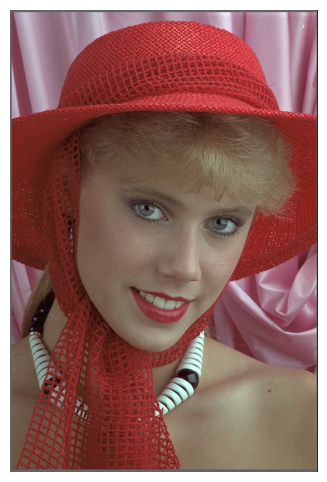

In [60]:
%matplotlib inline
plt.figure(figsize=(9, 6))
plt.axis('off')
plt.imshow(img)
plt.show()

### Run the networks

In [61]:
outputs = {}
with torch.no_grad():
    for name, net in networks.items():
        rv = net(x)
        rv['x_hat'].clamp_(0, 1)
        outputs[name] = rv

### Visualize the reconstructions

In [62]:
reconstructions = {name: transforms.ToPILImage()(out['x_hat'].squeeze())
                  for name, out in outputs.items()}

In [63]:
diffs = [torch.mean((out['x_hat'] - x).abs(), axis=1).squeeze()
        for out in outputs.values()]

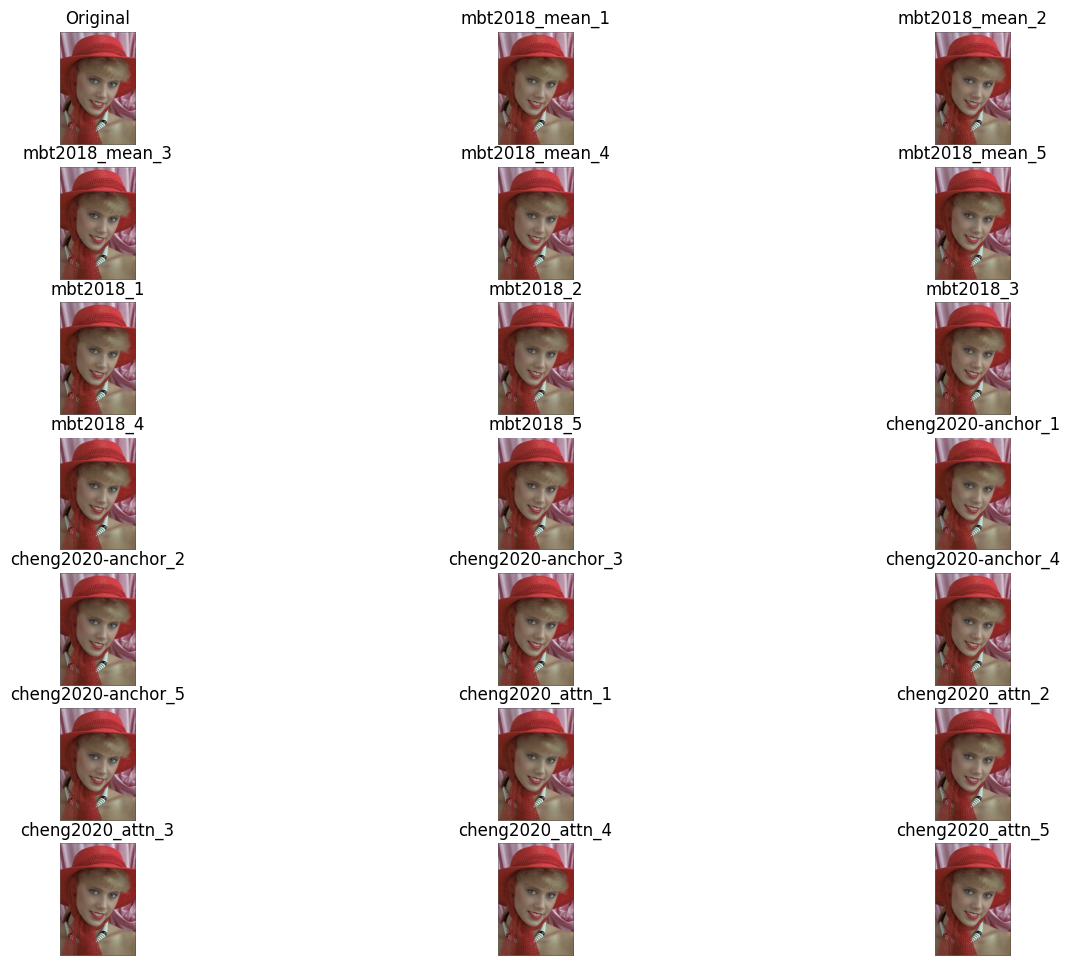

In [64]:
%matplotlib inline
fix, axes = plt.subplots((len(reconstructions) + 2)// 3, 3, figsize=(16, 12))
for ax in axes.ravel():
    ax.axis('off')
   
axes.ravel()[0].imshow(img)
axes.ravel()[0].title.set_text('Original')
    
for i, (name, rec) in enumerate(reconstructions.items()):
    axes.ravel()[i + 1].imshow(rec) # cropped for easy comparison
    axes.ravel()[i + 1].title.set_text(name)

plt.show()

## Metric

In [65]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [66]:
metrics = {}
for name, out in outputs.items():
    metrics[name] = {
        'psnr': compute_psnr(x, out["x_hat"]),
        'ms-ssim': compute_msssim(x, out["x_hat"]),
        'bit-rate': compute_bpp(out),
    }

In [67]:
header = f'{"Model":20s} | {"PSNR [dB]"} | {"MS-SSIM":<9s} | {"Bpp":<9s}|'
print('-'*len(header))
print(header)
print('-'*len(header))
for name, m in metrics.items():
    print(f'{name:20s}', end='')
    for v in m.values():
        print(f' | {v:9.3f}', end='')
    print('|')
print('-'*len(header))

---------------------------------------------------------
Model                | PSNR [dB] | MS-SSIM   | Bpp      |
---------------------------------------------------------
mbt2018_mean_1       |    28.963 |     0.903 |     0.084|
mbt2018_mean_2       |    30.470 |     0.928 |     0.129|
mbt2018_mean_3       |    33.628 |     0.967 |     0.312|
mbt2018_mean_4       |    35.284 |     0.978 |     0.462|
mbt2018_mean_5       |    37.086 |     0.986 |     0.680|
mbt2018_1            |    29.418 |     0.906 |     0.065|
mbt2018_2            |    30.776 |     0.929 |     0.118|
mbt2018_3            |    33.806 |     0.968 |     0.284|
mbt2018_4            |    35.470 |     0.978 |     0.438|
mbt2018_5            |    37.233 |     0.986 |     0.646|
cheng2020-anchor_1   |    29.654 |     0.909 |     0.067|
cheng2020-anchor_2   |    30.868 |     0.933 |     0.107|
cheng2020-anchor_3   |    33.927 |     0.969 |     0.264|
cheng2020-anchor_4   |    35.554 |     0.980 |     0.406|
cheng2020-anch

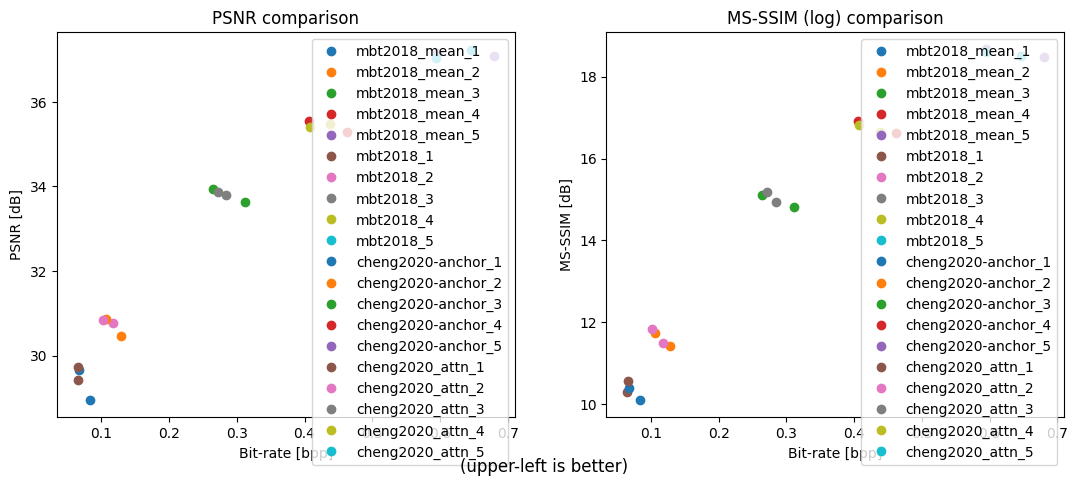

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
plt.figtext(.5, 0., '(upper-left is better)', fontsize=12, ha='center')
for name, m in metrics.items():
    axes[0].plot(m['bit-rate'], m['psnr'], 'o', label=name)
    axes[0].legend(loc='best')
    axes[0].grid()
    axes[0].set_ylabel('PSNR [dB]')
    axes[0].set_xlabel('Bit-rate [bpp]')
    axes[0].title.set_text('PSNR comparison')

    axes[1].plot(m['bit-rate'], -10*np.log10(1-m['ms-ssim']), 'o', label=name)
    axes[1].legend(loc='best')
    axes[1].grid()
    axes[1].set_ylabel('MS-SSIM [dB]')
    axes[1].set_xlabel('Bit-rate [bpp]')
    axes[1].title.set_text('MS-SSIM (log) comparison')

plt.show()